In [1]:
# %load_ext autoreload
# %autoreload 2

# Set Trial Name

In [2]:
TRIAL_NAME = "37_del_historical_person_info"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [3]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [4]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [5]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [6]:
import pandas as pd
import numpy as np

sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')

# maker = pd.read_csv('../../data/maker.csv')
maker = pd.read_csv('../../extract_data/maker_rename.csv')

material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')

#production_place = pd.read_csv('../../data/production_place.csv')
production_place = pd.read_csv('../../extract_data/production_place_rename.csv')

technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
test[cfg['target']] = np.nan
train = pd.read_csv('../../data/train.csv')

# del_non_overlapping_list

In [7]:
del_non_overlapping_list = [
    # 'object_id',
    'art_series_id',
    'title',
    #'description',
    #'long_title',
    'principal_maker',
    'principal_or_first_maker',
    #'sub_title',
    'copyright_holder',
    #'more_title',
    'acquisition_method',
    # 'acquisition_date',
    # 'acquisition_credit_line',
    # 'dating_presenting_date',
    # 'dating_sorting_date',
    'dating_period',
    # 'dating_year_early',
    # 'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

In [8]:
def del_non_overlapping(input_df: pd.DataFrame()):
    # for material
    train_oblect_id = train['object_id'].unique().tolist()
    test_oblect_id = test['object_id'].unique().tolist()

    train_value = set(input_df[input_df['object_id'].isin(train_oblect_id)]['name'].unique().tolist())
    test_value = set(input_df[input_df['object_id'].isin(test_oblect_id)]['name'].unique().tolist())

    common_value_list = list(train_value & test_value)

    return input_df[input_df['name'].isin(common_value_list)]

material = del_non_overlapping(material)
historical_person = del_non_overlapping(historical_person)
object_collection = del_non_overlapping(object_collection)
production_place = del_non_overlapping(production_place)

# Merge Data

In [9]:
group = train.groupby('principal_maker')

agg_df = pd.concat([
    group.size().rename('size'), # 著者が何回出てくるか. (value_counts と同じです)
    group['sub_title'].nunique().rename('sub_title_num'), # 著者ごとに何種類の sub_title を持っているか
    group['dating_sorting_date'].agg(['min', 'max', 'mean']), # 著者ごとに描いた年度の最小・最大・平均 (agg に配列を渡すと同時に複数やってくれます)
], axis=1)

agg_df.head()

,size,sub_title_num,min,max,mean
principal_maker,,,,,
A. Böeseken,5,5,1858.0,1873.0,1865.8
A. Lutz,1,1,1825.0,1825.0,1825.0
A. Mansuy,2,2,1860.0,1860.0,1860.0
A. Nissen,3,1,1860.0,1860.0,1860.0
A. Roussel,1,1,1905.0,1905.0,1905.0


In [10]:
train = pd.merge(train, 
         agg_df,
         on='principal_maker', 
         how='left')

test = pd.merge(test, 
         agg_df,
         on='principal_maker', 
         how='left')

In [11]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes', 'size', 'sub_title_num', 'min', 'max',
       'mean'],
      dtype='object')

# Feature Enginnering

In [12]:
def create_object_feature(input_df):        
    return input_df['likes'].copy()

create_object_feature(test).head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: likes, dtype: float64

In [13]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late'
    ]

    return input_df[use_columns].copy()

create_numeric_feature(train).head(2)

,dating_period,dating_year_early,dating_year_late
0,17,1660.0,1685.0
1,19,1900.0,1930.0


In [14]:
def create_categorical_feature(input_df):
    use_columns = [
    #'title',
    'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    ]

    return input_df[use_columns].copy()

create_categorical_feature(test)['principal_maker'].head()

0            Bernardus Bruining
1    Jan Antonisz van Ravesteyn
2               Theodoor Koning
3         Théodore van Lelyveld
4                    Jan Luyken
Name: principal_maker, dtype: object

In [15]:
import pycld2 as cld2

def create_lang_info(input_df):
    
    out_df = pd.DataFrame()
    
    out_df["title_lang"] = input_df["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
    return out_df

create_lang_info(train).head(2)

,title_lang
0,un
1,un


In [16]:
import re

def create_maker_feature(input_df):
    # 本当は時間の処理とかすべき。
    merge_df = pd.merge(input_df['principal_maker'], maker, left_on='principal_maker', right_on='name',how='left')
    merge_df = merge_df.fillna('missing')

    def get_year(text: str):
        match = re.search(r'[0-9]{4}', text)
        if match:
            return match.group()
        else:
            return np.nan
        
    def get_month(text: str):
        match = re.search(r'-[0-9]{2}-', text)
        if match:
            return match.group()[1:-1]
        else:
            return np.nan
    
    # year
    merge_df['date_of_birth_year'] = merge_df['date_of_birth'].apply(lambda x : get_year(x)).astype('float')
    merge_df['date_of_death_year'] = merge_df['date_of_death'].apply(lambda x : get_year(x)).astype('float')
    
    # month
    merge_df['date_of_birth_month'] = merge_df['date_of_birth'].apply(lambda x : get_month(x)).astype('float')
    merge_df['date_of_death_month'] = merge_df['date_of_death'].apply(lambda x : get_month(x)).astype('float')
    
    del_list = [
        'Unnamed: 0',
        'place_of_birth',
        'place_of_death',
        'principal_maker'
    ]
    
    merge_df = merge_df.drop(del_list,axis=1)
    
    return merge_df

create_maker_feature(train).head(2)

,name,date_of_birth,date_of_death,nationality,place_of_birth_country_name,place_of_death_country_name,date_of_birth_year,date_of_death_year,date_of_birth_month,date_of_death_month
0,Jan Hackaert,1628,1705,missing,Netherlands,Netherlands,1628.0,1705.0,NaN,NaN
1,Richard Tepe,1864,1952,missing,Netherlands,Netherlands,1864.0,1952.0,NaN,NaN


In [17]:
def create_material_feature(input_df):
    
    out_df = pd.DataFrame()

    material_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_w2v.csv')
    material_collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_w2v.csv')
    material_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_technique_w2v.csv')
    material_collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_w2v.csv')
    material_collection_technique_production_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_w2v.csv')
    material_collection_technique_production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/material_collection_technique_production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], material_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, material_collection_technique_production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]

create_material_feature(train).head(2)

,material_w2v_0,material_w2v_1,material_w2v_2,material_w2v_3,material_w2v_4,material_w2v_5,material_w2v_6,material_w2v_7,material_w2v_8,material_w2v_9,...,material_collection_technique_production_country_w2v_20,material_collection_technique_production_country_w2v_21,material_collection_technique_production_country_w2v_22,material_collection_technique_production_country_w2v_23,material_collection_technique_production_country_w2v_24,material_collection_technique_production_country_w2v_25,material_collection_technique_production_country_w2v_26,material_collection_technique_production_country_w2v_27,material_collection_technique_production_country_w2v_28,material_collection_technique_production_country_w2v_29
0,0.278293,-0.231511,-0.662789,0.991121,0.265224,0.322988,0.102308,-0.456635,-0.190513,-0.944719,...,-0.322543,-0.111608,0.591859,-0.245983,-0.657963,-0.485101,-1.523239,0.461789,0.381441,0.069295
1,0.588832,1.351733,-0.972135,0.362667,-0.376671,-1.124974,0.475698,0.625674,0.555431,-0.876702,...,0.479570,0.600997,-0.478906,-0.229830,1.112767,-0.622317,-0.249008,-0.773201,0.224783,-0.254743


In [18]:
def create_object_collection_feature(input_df):
    collection_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_w2v.csv')
    collection_technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/collection_technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], collection_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, collection_technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_object_collection_feature(train).head(2)

,collection_w2v_0,collection_w2v_1,collection_w2v_2,collection_technique_w2v_0,collection_technique_w2v_1,collection_technique_w2v_2,collection_technique_w2v_3,collection_technique_w2v_4,collection_technique_w2v_5,collection_technique_w2v_6,collection_technique_w2v_7,collection_technique_w2v_8,collection_technique_w2v_9
0,-0.649585,-0.883449,1.056636,-0.802673,-0.773696,2.710698,0.041548,-0.239502,-0.667183,-0.838723,-0.637467,0.571580,-0.086521
1,NaN,NaN,NaN,-0.155195,-0.252811,0.461979,0.062138,-0.218526,-0.039926,-0.068988,-0.283977,0.272564,-0.126860


In [19]:
def create_technique_feature(input_df):
    technique_w2v = pd.read_csv('../../../my_pipeline/extract_data/technique_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], technique_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:]
  
create_technique_feature(train).head(2)

,technique_w2v_0,technique_w2v_1,technique_w2v_2,technique_w2v_3,technique_w2v_4,technique_w2v_5,technique_w2v_6,technique_w2v_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.230237,-0.075641,0.27766,-0.29013,-0.180698,0.399966,0.128924,-0.01231


In [20]:
def create_historical_person_feature(input_df):
    vc = historical_person['name'].value_counts()
    
    # 出現回数30以上に絞る
    use_names = vc[vc >= 30].index
    
    # isin で 30 回以上でてくるようなレコードに絞り込んでから crosstab を行なう
    idx = historical_person['name'].isin(use_names)
    historical_person_only_famous = historical_person[idx].reset_index(drop=True)
    #print(historical_person_only_famous)
        
    cross_historical_person = pd.crosstab(historical_person_only_famous['object_id'], historical_person_only_famous['name']).reset_index()
    
    input_historical_person = pd.merge(input_df['object_id'], cross_historical_person, on='object_id',how='left')
    input_historical_person.columns = [col.replace(',','') for col in input_historical_person.columns]
    return input_historical_person.iloc[:,1:].add_prefix('HistoricalPerson_')
  
create_historical_person_feature(train).head(2)

,HistoricalPerson_Djatiroto Suikeronderneming,HistoricalPerson_Frederik Hendrik (prins van Oranje),HistoricalPerson_Handels Vereeniging Amsterdam,HistoricalPerson_Jacobus II (koning van Engeland en Schotland),HistoricalPerson_Lodewijk XIV (koning van Frankrijk),HistoricalPerson_Maria II Stuart (koningin van Engeland Schotland en Ierland),HistoricalPerson_Maurits (prins van Oranje),HistoricalPerson_Musschenbroek Sam van,HistoricalPerson_Oldenbarnevelt Johan van,HistoricalPerson_Ruyter Michiel Adriaansz. de,...,HistoricalPerson_Wilhelm II (keizer van Duitsland),HistoricalPerson_Wilhelmina (koningin der Nederlanden),HistoricalPerson_Willem I (prins van Oranje),HistoricalPerson_Willem III (koning der Nederlanden),HistoricalPerson_Willem III (prins van Oranje en koning van Engeland Schotland en Ierland),HistoricalPerson_Willem V (prins van Oranje-Nassau),HistoricalPerson_Wirix F.J.,HistoricalPerson_Witt Cornelis de,HistoricalPerson_Witt Johan de,HistoricalPerson_Álvarez de Toledo Fernando (3e hertog van Alva)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def create_production_place_feature(input_df):

    out_df = pd.DataFrame()

    prodcution_w2v = pd.read_csv('../../../my_pipeline/extract_data/prodcution_w2v.csv')
    production_country_w2v = pd.read_csv('../../../my_pipeline/extract_data/production_country_w2v.csv')
    
    out_df = pd.merge(input_df['object_id'], prodcution_w2v, on='object_id', how='left')
    out_df = pd.merge(out_df, production_country_w2v, on='object_id', how='left')
    
    return out_df.iloc[:,1:].add_prefix('ProductionPlace_')
  
create_production_place_feature(test).head(2)

,ProductionPlace_production_w2v_0,ProductionPlace_production_w2v_1,ProductionPlace_production_w2v_2,ProductionPlace_production_w2v_3,ProductionPlace_production_w2v_4,ProductionPlace_production_w2v_5,ProductionPlace_production_w2v_6,ProductionPlace_production_w2v_7,ProductionPlace_production_w2v_8,ProductionPlace_production_w2v_9,...,ProductionPlace_production_country_w2v_10,ProductionPlace_production_country_w2v_11,ProductionPlace_production_country_w2v_12,ProductionPlace_production_country_w2v_13,ProductionPlace_production_country_w2v_14,ProductionPlace_production_country_w2v_15,ProductionPlace_production_country_w2v_16,ProductionPlace_production_country_w2v_17,ProductionPlace_production_country_w2v_18,ProductionPlace_production_country_w2v_19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import datetime

def create_acquisition_feature(input_df):
    out_df = pd.DataFrame()
    
    use_columns = [
        'acquisition_date'
    ]
    
    out_df['year'] = pd.to_datetime(input_df['acquisition_date']).dt.year
    out_df['month'] = pd.to_datetime(input_df['acquisition_date']).dt.month
    out_df['dayofweek'] = pd.to_datetime(input_df['acquisition_date']).dt.dayofweek
    out_df['sum_time'] =  10**10 - pd.to_datetime(input_df['acquisition_date']).view('int') // 10**9
    
    return out_df.add_prefix('AcquisitionDate_')

create_acquisition_feature(train).head(2)

,AcquisitionDate_year,AcquisitionDate_month,AcquisitionDate_dayofweek,AcquisitionDate_sum_time
0,1808.0,1.0,4.0,15112288000
1,2000.0,1.0,5.0,9053315200


In [23]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
        'description',
        'principal_maker',
        'principal_or_first_maker'
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength__')

create_string_length_feature(train).head(2)

,StringLength__title,StringLength__long_title,StringLength__sub_title,StringLength__more_title,StringLength__description,StringLength__principal_maker,StringLength__principal_or_first_maker
0,5,48,39.0,21.0,NaN,12,12
1,5,64,17.0,15.0,NaN,12,12


In [24]:
def create_count_encoding_feature(input_df):
    use_columns = [
        'acquisition_method',
        'acquisition_date',
        'acquisition_credit_line',
        #'art_series_id', 
        'principal_maker',
        'principal_or_first_maker',
        'description', 
        'dating_presenting_date',
        'dating_sorting_date',
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'title',
        'long_title',
        'sub_title',
        'copyright_holder',
        'more_title',
    ]

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = train[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

create_count_encoding_feature(train).head(2)

,CE_acquisition_method,CE_acquisition_date,CE_acquisition_credit_line,CE_principal_maker,CE_principal_or_first_maker,CE_description,CE_dating_presenting_date,CE_dating_sorting_date,CE_dating_period,CE_dating_year_early,CE_dating_year_late,CE_title,CE_long_title,CE_sub_title,CE_copyright_holder,CE_more_title
0,4253,48.0,NaN,3,3,NaN,3.0,65.0,3005,65.0,30.0,10516,1,1.0,11313,1.0
1,4253,231.0,NaN,180,180,NaN,77.0,321.0,5042,321.0,214.0,10516,1,1.0,180,1.0


In [25]:
# def create_one_hot_encoding(input_df):
#     use_columns = [
#         'acquisition_method',
#         'principal_maker'
#     ]
#     out_df = pd.DataFrame()
#     for column in use_columns:

#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = train[column].value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(input_df[column], categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

# create_one_hot_encoding(train).head(2)

In [26]:
import re

#  h 166mm × w 78/54mm

def get_h_from_subtitle(text:str):
    match_cm = re.search(r'h \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'h \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100

def get_w_from_subtitle(text:str):
    match_cm = re.search(r'w \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'w \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        elif match_mm.group()[2:-2] == '78/54':
            return float(78)
        else:
            return float(match_mm.group()[2:-2])/100    

def get_t_from_subtitle(text:str):
    match_cm = re.search(r't \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r't \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   

def get_d_from_subtitle(text:str):
    match_cm = re.search(r'd \S+cm', text)
    if match_cm:
        if match_cm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_cm.group()[2:-2])

    match_mm = re.search(r'd \S+mm', text)
    if match_mm:
        if match_mm.group()[2:-2] == '':
            return np.nan
        else:
            return float(match_mm.group()[2:-2])/100   
        
def create_subtitle_info(input_df):
    out_df = pd.DataFrame()
     
    out_df['subtitle_h'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_h_from_subtitle(x))
    out_df['subtitle_w'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_w_from_subtitle(x))
    out_df['subtitle_t'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_t_from_subtitle(x))
    out_df['subtitle_d'] = input_df['sub_title'].fillna('missing').apply(lambda x : get_d_from_subtitle(x))
    
    out_df['area'] = out_df['subtitle_h'] * out_df['subtitle_w']
    out_df['volume'] = out_df['subtitle_h'] * out_df['subtitle_w'] * out_df['subtitle_t']

    return out_df

create_subtitle_info(test).head(2)

,subtitle_h,subtitle_w,subtitle_t,subtitle_d,area,volume
0,1.67,1.08,NaN,NaN,1.8036,NaN
1,29.70,24.10,NaN,NaN,715.7700,NaN


In [27]:
from util import use_pca

def create_description_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_description_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('DescriptionEmb_')

create_description_emb(test).tail(2)

,DescriptionEmb_pca_0,DescriptionEmb_pca_1,DescriptionEmb_pca_2,DescriptionEmb_pca_3,DescriptionEmb_pca_4,DescriptionEmb_pca_5,DescriptionEmb_pca_6,DescriptionEmb_pca_7,DescriptionEmb_pca_8,DescriptionEmb_pca_9,...,DescriptionEmb_pca_246,DescriptionEmb_pca_247,DescriptionEmb_pca_248,DescriptionEmb_pca_249,DescriptionEmb_pca_250,DescriptionEmb_pca_251,DescriptionEmb_pca_252,DescriptionEmb_pca_253,DescriptionEmb_pca_254,DescriptionEmb_pca_255
12006,4.868668,-2.158481,0.022857,0.005380,-0.005051,-0.033196,-0.030381,0.001403,-0.000757,-0.003157,...,-0.000064,-0.000067,-0.000091,0.000008,0.000044,-0.000033,0.000201,0.000045,-0.000024,-0.000100
12007,-2.857192,-0.279424,-1.757069,-0.255253,-0.783501,-0.267247,-0.262805,-0.261656,0.870815,-0.289136,...,-0.001994,-0.026316,0.001796,-0.004356,0.023299,0.019852,0.020951,0.001647,0.005704,0.004972


In [28]:
from util import use_pca

def create_longtitle_emb(input_df):
    out_df = pd.DataFrame()
    
    all_emb_df = pd.read_pickle('../../extract_data/all_longtitle_emb_multilingual.pkl')

    emb_df_256 = use_pca(all_emb_df.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat((all_emb_df['object_id'], emb_df_256), axis=1)
    
    input_word_emb = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    # return input_word_emb[[num for num in range(768)]].add_prefix('DescriptionEmb_')
    return input_word_emb[[f'pca_{num}' for num in range(256)]].add_prefix('LongTitleEmb_')

create_longtitle_emb(train).tail(2)

,LongTitleEmb_pca_0,LongTitleEmb_pca_1,LongTitleEmb_pca_2,LongTitleEmb_pca_3,LongTitleEmb_pca_4,LongTitleEmb_pca_5,LongTitleEmb_pca_6,LongTitleEmb_pca_7,LongTitleEmb_pca_8,LongTitleEmb_pca_9,...,LongTitleEmb_pca_246,LongTitleEmb_pca_247,LongTitleEmb_pca_248,LongTitleEmb_pca_249,LongTitleEmb_pca_250,LongTitleEmb_pca_251,LongTitleEmb_pca_252,LongTitleEmb_pca_253,LongTitleEmb_pca_254,LongTitleEmb_pca_255
12024,0.134985,0.274562,-0.355269,-0.568043,0.490877,-0.759765,0.800043,0.492068,-0.684610,-0.055678,...,-0.124074,-0.109663,0.011206,0.033923,-0.071635,0.004939,0.036290,-0.151617,0.046685,0.075895
12025,3.315138,0.391916,-0.387958,-0.729402,-0.963970,-1.700653,-0.560265,0.077447,0.027752,-0.265692,...,0.011086,-0.019667,0.018910,-0.077004,-0.060062,-0.031613,0.043291,0.041124,0.057003,0.006189


In [29]:
from util import use_pca

def create_image_feature(input_df):
    out_df = pd.DataFrame()
    
    all_image_feature = pd.read_pickle('../../extract_data/all_image_feature.pkl').reset_index(drop='True')

    all_image_feature_256 = use_pca(all_image_feature.iloc[:,1:], 256)
    all_emb_df_256 = pd.concat([all_image_feature['object_id'], all_image_feature_256], axis=1)
    
    input_image_feature = pd.merge(input_df['object_id'], all_emb_df_256, on='object_id', how='left')
    
    return input_image_feature.iloc[:,1:].add_prefix('ImageFeature_')

create_image_feature(test).head()

,ImageFeature_pca_0,ImageFeature_pca_1,ImageFeature_pca_2,ImageFeature_pca_3,ImageFeature_pca_4,ImageFeature_pca_5,ImageFeature_pca_6,ImageFeature_pca_7,ImageFeature_pca_8,ImageFeature_pca_9,...,ImageFeature_pca_246,ImageFeature_pca_247,ImageFeature_pca_248,ImageFeature_pca_249,ImageFeature_pca_250,ImageFeature_pca_251,ImageFeature_pca_252,ImageFeature_pca_253,ImageFeature_pca_254,ImageFeature_pca_255
0,-0.005688,-0.125414,-0.092007,0.026604,-0.018229,0.295779,-0.048568,-0.108167,-0.001396,0.025950,...,-0.000041,0.000005,-0.000002,-0.000003,-8.172306e-06,-0.000019,2.598678e-05,0.000027,-1.801875e-07,-0.000021
1,0.143516,0.010304,-0.013216,-0.099269,0.077683,0.000408,-0.024514,0.003251,-0.017895,0.026756,...,-0.000186,-0.000225,-0.000288,0.000275,-1.365183e-05,-0.000135,8.509834e-06,0.000019,5.110624e-05,-0.000113
2,-0.106839,-0.035884,0.057630,0.017206,0.004653,-0.036550,0.045559,-0.038160,0.008273,-0.010530,...,-0.000003,0.000011,0.000030,0.000022,8.877284e-06,-0.000038,-2.559310e-05,-0.000008,-2.151790e-05,0.000037
3,-0.074211,-0.043712,0.046767,-0.068886,-0.022720,0.061847,-0.074479,-0.031685,-0.004385,-0.003143,...,0.000103,0.000087,-0.000080,0.000021,-8.396307e-05,0.000036,-3.438375e-05,0.000065,-8.417264e-05,0.000037
4,-0.087378,0.081600,0.005646,-0.009279,-0.023805,-0.010688,0.019533,0.000312,0.003025,-0.002274,...,-0.000008,-0.000006,-0.000022,0.000017,3.809838e-07,-0.000006,-1.555337e-07,-0.000008,-3.870759e-06,-0.000002


In [30]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [31]:
from tqdm import tqdm

def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_object_feature,
        create_numeric_feature,
        create_categorical_feature,
        create_lang_info,
        create_maker_feature,
        #create_historical_person_feature,
        create_material_feature,
        create_object_collection_feature,
        create_technique_feature,
        create_production_place_feature,
        create_acquisition_feature,
        ### create_principal_maker_info_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        #create_one_hot_encoding,
        create_subtitle_info,
        create_description_emb,
        create_longtitle_emb,
        create_image_feature
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)
        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

train_feat= to_feature(train)
test_feat = to_feature(test)

train = train_feat.copy()
test = test_feat.copy()

 31%|███▏      | 5/16 [00:00<00:00, 33.14it/s]

createcreate_object_feature  0.001[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.062[s]
createcreate_maker_feature  0.069[s]


 50%|█████     | 8/16 [00:00<00:01,  6.25it/s]

createcreate_material_feature  0.577[s]
createcreate_object_collection_feature  0.059[s]
createcreate_technique_feature  0.033[s]


 69%|██████▉   | 11/16 [00:01<00:00,  7.97it/s]

createcreate_production_place_feature  0.122[s]
createcreate_acquisition_feature  0.014[s]
createcreate_string_length_feature  0.027[s]
createcreate_count_encoding_feature  0.054[s]


 81%|████████▏ | 13/16 [00:01<00:00,  8.39it/s]

createcreate_subtitle_info  0.081[s]
createcreate_description_emb  1.237[s]


 94%|█████████▍| 15/16 [00:03<00:00,  2.13it/s]

createcreate_longtitle_emb  1.249[s]


  0%|          | 0/16 [00:00<?, ?it/s]

createcreate_image_feature  1.538[s]
createcreate_object_feature  0.000[s]
createcreate_numeric_feature  0.001[s]
createcreate_categorical_feature  0.002[s]
createcreate_lang_info  0.051[s]
createcreate_maker_feature  0.062[s]


 44%|████▍     | 7/16 [00:00<00:01,  8.08it/s]

createcreate_material_feature  0.601[s]
createcreate_object_collection_feature  0.062[s]
createcreate_technique_feature  0.034[s]


 69%|██████▉   | 11/16 [00:01<00:00, 10.12it/s]

createcreate_production_place_feature  0.118[s]
createcreate_acquisition_feature  0.014[s]
createcreate_string_length_feature  0.031[s]
createcreate_count_encoding_feature  0.060[s]


 81%|████████▏ | 13/16 [00:01<00:00,  9.82it/s]

createcreate_subtitle_info  0.083[s]
createcreate_description_emb  1.282[s]


 94%|█████████▍| 15/16 [00:04<00:00,  2.03it/s]

createcreate_longtitle_emb  1.371[s]


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

createcreate_image_feature  2.574[s]


In [32]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [33]:
# train.to_csv('../EDA/train_for_EDA.csv')
# test.to_csv('../EDA/test_for_EDA.csv')

# train

In [34]:
train.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,ImageFeature_pca_246,ImageFeature_pca_247,ImageFeature_pca_248,ImageFeature_pca_249,ImageFeature_pca_250,ImageFeature_pca_251,ImageFeature_pca_252,ImageFeature_pca_253,ImageFeature_pca_254,ImageFeature_pca_255
0,48,17,1660.0,1685.0,other,Jan Hackaert,Jan Hackaert,missing,purchase,un,...,0.000035,0.000021,0.000008,-0.000031,-0.000192,-0.000032,0.000007,0.000025,0.000066,0.000016
1,2,19,1900.0,1930.0,other,Richard Tepe,Richard Tepe,erven Richard Tepe,purchase,un,...,0.000024,-0.000039,0.000031,-0.000009,-0.000028,-0.000101,0.000019,-0.000027,0.000016,-0.000045


In [35]:
# import collections

# collections.Counter(train.columns.tolist())

In [36]:
test.head(2)

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,ImageFeature_pca_246,ImageFeature_pca_247,ImageFeature_pca_248,ImageFeature_pca_249,ImageFeature_pca_250,ImageFeature_pca_251,ImageFeature_pca_252,ImageFeature_pca_253,ImageFeature_pca_254,ImageFeature_pca_255
0,NaN,19,1850.0,1900.0,other,Bernardus Bruining,Bernardus Bruining,missing,transfer,un,...,-0.000037,-0.000005,4.899888e-08,-0.000007,0.000016,0.000002,-0.000043,-0.000038,0.000010,0.000007
1,NaN,17,1609.0,1633.0,other,Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,missing,nationalization 1795,un,...,-0.000249,-0.000391,-8.105000e-06,0.000091,0.000153,0.000073,-0.000043,0.000044,0.000096,0.000135


# reduce mem usage

In [37]:
from util import reduce_mem_usage
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 24.45 Mb (58.6% reduction)
Mem. usage decreased to 24.50 Mb (58.4% reduction)


# del_non_overlapping 2

In [38]:
train, test = replace_non_overlap_val_to_missing(train,test,columns=['title_lang'])

# Lable Encoding

In [39]:
cat_col = train.select_dtypes('O').columns.tolist()

In [40]:
cat_col

['art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'date_of_birth',
 'date_of_death',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name']

In [41]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [42]:
train.dtypes

likes                     int16
dating_period              int8
dating_year_early       float16
dating_year_late        float16
art_series_id             int64
                         ...   
ImageFeature_pca_251    float16
ImageFeature_pca_252    float16
ImageFeature_pca_253    float16
ImageFeature_pca_254    float16
ImageFeature_pca_255    float16
Length: 1027, dtype: object

# add fold

In [43]:
from fold import add_fold_bin_skf
train = add_fold_bin_skf(train, train[cfg['target']], fold_num=5, bins=[0,1,10,100,1000, 27392])

# Target Encoding

In [44]:
target_enc_list = [
    # 'title',
    # 'art_series_id',
    'principal_maker',
    'principal_or_first_maker',
    'copyright_holder',
    'acquisition_method',
    'dating_period',
    'title_lang'
]

from fe import target_encoding
train, test = target_encoding(train, 
                              test, 
                              target = cfg['target'], 
                              target_enc_list = target_enc_list, 
                              fold_num = cfg['fold_num']
                             )

principal_maker
principal_or_first_maker
copyright_holder
acquisition_method
dating_period
title_lang


# Make Model

In [45]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [46]:
use_col

['dating_period',
 'dating_year_early',
 'dating_year_late',
 'art_series_id',
 'principal_maker',
 'principal_or_first_maker',
 'copyright_holder',
 'acquisition_method',
 'title_lang',
 'name',
 'date_of_birth',
 'date_of_death',
 'nationality',
 'place_of_birth_country_name',
 'place_of_death_country_name',
 'date_of_birth_year',
 'date_of_death_year',
 'date_of_birth_month',
 'date_of_death_month',
 'material_w2v_0',
 'material_w2v_1',
 'material_w2v_2',
 'material_w2v_3',
 'material_w2v_4',
 'material_w2v_5',
 'material_w2v_6',
 'material_w2v_7',
 'material_w2v_8',
 'material_w2v_9',
 'material_w2v_10',
 'material_w2v_11',
 'material_w2v_12',
 'material_w2v_13',
 'material_w2v_14',
 'material_w2v_15',
 'material_w2v_16',
 'material_w2v_17',
 'material_w2v_18',
 'material_w2v_19',
 'material_collection_w2v_0',
 'material_collection_w2v_1',
 'material_collection_w2v_2',
 'material_collection_w2v_3',
 'material_collection_w2v_4',
 'material_collection_w2v_5',
 'material_collection_w2

In [47]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)

wandb: Currently logged in as: sinchir0 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [48]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False,
  is_target_log=True)

feature_importance_df, order = lgbm.feature_importance(PLOT=False)

--------------FOLDS : 0 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17574	valid_1's rmse: 1.21432
[200]	training's rmse: 1.00976	valid_1's rmse: 1.097
[300]	training's rmse: 0.938032	valid_1's rmse: 1.06776
[400]	training's rmse: 0.886349	valid_1's rmse: 1.05511
[500]	training's rmse: 0.843449	valid_1's rmse: 1.04758
[600]	training's rmse: 0.805587	valid_1's rmse: 1.04307
[700]	training's rmse: 0.770958	valid_1's rmse: 1.03887
[800]	training's rmse: 0.73931	valid_1's rmse: 1.03556
[900]	training's rmse: 0.710062	valid_1's rmse: 1.033
[1000]	training's rmse: 0.682475	valid_1's rmse: 1.03046
[1100]	training's rmse: 0.656644	valid_1's rmse: 1.02845
[1200]	training's rmse: 0.63216	valid_1's rmse: 1.02659
[1300]	training's rmse: 0.609316	valid_1's rmse: 1.02448
[1400]	training's rmse: 0.58753	valid_1's rmse: 1.02322
[1500]	training's rmse: 0.566718	valid_1's rmse: 1.02185
[1600]	training's rmse: 0.54726	valid_1's rmse: 1.02085
[1700]	training's rmse: 0.528623	valid_1's rm

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17054	valid_1's rmse: 1.21983
[200]	training's rmse: 1.00463	valid_1's rmse: 1.10942
[300]	training's rmse: 0.932694	valid_1's rmse: 1.0841
[400]	training's rmse: 0.882397	valid_1's rmse: 1.07353
[500]	training's rmse: 0.839639	valid_1's rmse: 1.06666
[600]	training's rmse: 0.801766	valid_1's rmse: 1.06188
[700]	training's rmse: 0.767236	valid_1's rmse: 1.05695
[800]	training's rmse: 0.735182	valid_1's rmse: 1.05334
[900]	training's rmse: 0.705883	valid_1's rmse: 1.04956
[1000]	training's rmse: 0.678565	valid_1's rmse: 1.0471
[1100]	training's rmse: 0.653025	valid_1's rmse: 1.0447
[1200]	training's rmse: 0.628762	valid_1's rmse: 1.04244
[1300]	training's rmse: 0.606015	valid_1's rmse: 1.04079
[1400]	training's rmse: 0.5845	valid_1's rmse: 1.03869
[1500]	training's rmse: 0.563801	valid_1's rmse: 1.03765
[1600]	training's rmse: 0.54443	valid_1's rmse: 1.03672
[1700]	training's rmse: 0.526057	valid_1's 

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.1771	valid_1's rmse: 1.21058
[200]	training's rmse: 1.01309	valid_1's rmse: 1.09522
[300]	training's rmse: 0.942131	valid_1's rmse: 1.06642
[400]	training's rmse: 0.890717	valid_1's rmse: 1.05204
[500]	training's rmse: 0.847769	valid_1's rmse: 1.04402
[600]	training's rmse: 0.809417	valid_1's rmse: 1.03805
[700]	training's rmse: 0.774381	valid_1's rmse: 1.03374
[800]	training's rmse: 0.742049	valid_1's rmse: 1.02956
[900]	training's rmse: 0.712269	valid_1's rmse: 1.02611
[1000]	training's rmse: 0.684229	valid_1's rmse: 1.02342
[1100]	training's rmse: 0.658033	valid_1's rmse: 1.02083
[1200]	training's rmse: 0.633394	valid_1's rmse: 1.01925
[1300]	training's rmse: 0.61026	valid_1's rmse: 1.01754
[1400]	training's rmse: 0.588248	valid_1's rmse: 1.01604
[1500]	training's rmse: 0.567208	valid_1's rmse: 1.01442
[1600]	training's rmse: 0.547743	valid_1's rmse: 1.01349
[1700]	training's rmse: 0.528946	valid_

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17119	valid_1's rmse: 1.23299
[200]	training's rmse: 1.00565	valid_1's rmse: 1.12448
[300]	training's rmse: 0.934399	valid_1's rmse: 1.0973
[400]	training's rmse: 0.882949	valid_1's rmse: 1.08397
[500]	training's rmse: 0.840433	valid_1's rmse: 1.0761
[600]	training's rmse: 0.802006	valid_1's rmse: 1.06949
[700]	training's rmse: 0.767472	valid_1's rmse: 1.06446
[800]	training's rmse: 0.735628	valid_1's rmse: 1.06018
[900]	training's rmse: 0.706068	valid_1's rmse: 1.05791
[1000]	training's rmse: 0.678269	valid_1's rmse: 1.05543
[1100]	training's rmse: 0.652555	valid_1's rmse: 1.05268
[1200]	training's rmse: 0.628495	valid_1's rmse: 1.05048
[1300]	training's rmse: 0.605383	valid_1's rmse: 1.04864
[1400]	training's rmse: 0.583603	valid_1's rmse: 1.04712
[1500]	training's rmse: 0.56322	valid_1's rmse: 1.04545
[1600]	training's rmse: 0.5437	valid_1's rmse: 1.0443
[1700]	training's rmse: 0.525163	valid_1's 

/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_method', 'art_series_id', 'copyright_holder', 'date_of_birth', 'date_of_death', 'name', 'nationality', 'place_of_birth_country_name', 'place_of_death_country_name', 'principal_maker', 'principal_or_first_maker', 'title_lang']
  warnings.warn('categorical_feature in Dataset is overridden.\n

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.17555	valid_1's rmse: 1.22247
[200]	training's rmse: 1.01052	valid_1's rmse: 1.10157
[300]	training's rmse: 0.938751	valid_1's rmse: 1.07076
[400]	training's rmse: 0.887345	valid_1's rmse: 1.05695
[500]	training's rmse: 0.843917	valid_1's rmse: 1.04907
[600]	training's rmse: 0.805367	valid_1's rmse: 1.043
[700]	training's rmse: 0.770192	valid_1's rmse: 1.03831
[800]	training's rmse: 0.737785	valid_1's rmse: 1.03486
[900]	training's rmse: 0.707773	valid_1's rmse: 1.03216
[1000]	training's rmse: 0.679864	valid_1's rmse: 1.02962
[1100]	training's rmse: 0.65386	valid_1's rmse: 1.02766
[1200]	training's rmse: 0.629216	valid_1's rmse: 1.02632
[1300]	training's rmse: 0.606128	valid_1's rmse: 1.02463
[1400]	training's rmse: 0.584324	valid_1's rmse: 1.02374
[1500]	training's rmse: 0.563635	valid_1's rmse: 1.02279
[1600]	training's rmse: 0.544184	valid_1's rmse: 1.0219
[1700]	training's rmse: 0.525625	valid_1'

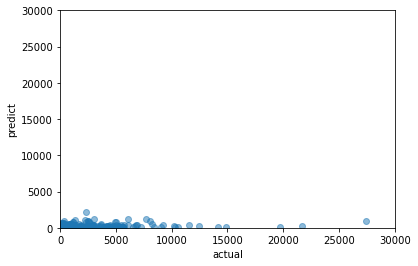

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(train['likes'],lgbm.oof,alpha=0.5);
plt.xlim(0,30000);
plt.ylim(0,30000);
plt.xlabel('actual');
plt.ylabel('predict');

In [63]:
train[train['likes'] < 50]

,likes,dating_period,dating_year_early,dating_year_late,art_series_id,principal_maker,principal_or_first_maker,copyright_holder,acquisition_method,title_lang,...,ImageFeature_pca_253,ImageFeature_pca_254,ImageFeature_pca_255,fold,principal_maker_target_enc,principal_or_first_maker_target_enc,copyright_holder_target_enc,acquisition_method_target_enc,dating_period_target_enc,title_lang_target_enc
0,48,17,1660.0,1685.0,0,638,638,25,6,13,...,0.000025,0.000066,0.000016,0,34.000000,34.000000,84.717660,93.411989,166.412056,81.003403
1,2,19,1900.0,1930.0,0,1042,1041,23,6,13,...,-0.000027,0.000016,-0.000045,0,12.470588,12.470588,12.470588,93.411989,54.370800,81.003403
2,5,19,1860.0,1880.0,0,1202,1212,25,2,10,...,NaN,NaN,NaN,0,159.857923,158.856244,84.717660,62.250801,54.370800,4.427848
4,7,19,1825.0,1874.0,0,1194,1194,25,8,13,...,0.000014,-0.000100,0.000070,0,22.865972,23.358289,84.717660,11.147402,54.370800,81.003403
5,0,19,1867.0,1867.0,0,174,175,25,2,13,...,0.000050,0.000006,0.000007,0,3.000000,3.000000,84.717660,62.250801,54.370800,81.003403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12020,6,20,1935.0,1936.0,0,1194,1194,25,6,13,...,-0.000062,-0.000027,-0.000086,4,23.889527,24.341410,83.251353,90.179818,36.716475,77.494111
12021,4,19,1900.0,1920.0,0,295,296,25,7,13,...,-0.000011,0.000006,-0.000017,4,NaN,NaN,83.251353,20.151635,58.355755,77.494111
12022,0,18,1701.0,1714.0,0,13,13,25,6,13,...,0.000061,0.000006,0.000005,4,0.444444,0.444444,83.251353,90.179818,55.729022,77.494111
12023,0,18,1778.0,1778.0,0,916,915,25,7,13,...,0.000005,-0.000023,-0.000001,4,1.000000,1.000000,83.251353,20.151635,55.729022,77.494111


In [50]:
os.makedirs(f"{OUTPUT_DIR}/imp", exist_ok=True)
feature_importance_df[order[:50]].to_csv(f"{OUTPUT_DIR}/imp/importance.csv")
display(feature_importance_df[order[:50]])

,material_collection_technique_w2v_19,material_collection_w2v_19,material_collection_technique_w2v_3,principal_maker,subtitle_h,material_collection_technique_production_country_w2v_7,collection_w2v_1,collection_technique_w2v_2,principal_or_first_maker,principal_or_first_maker_target_enc,...,LongTitleEmb_pca_138,LongTitleEmb_pca_253,ImageFeature_pca_8,LongTitleEmb_pca_110,DescriptionEmb_pca_40,LongTitleEmb_pca_8,StringLength__description,AcquisitionDate_year,LongTitleEmb_pca_0,DescriptionEmb_pca_48
fold_0,186516.928873,86282.004589,125417.031528,33631.229697,11400.763077,28760.551583,13433.806793,24812.915717,13357.815701,20360.415761,...,1051.810703,1112.249798,992.584062,1450.874782,1070.313474,1413.838286,1704.843863,1058.062109,1019.235118,2224.853549
fold_1,116697.959103,82712.233428,220493.372744,33071.268577,12982.447784,40331.978712,1117.150024,4596.621959,19197.843426,18767.585271,...,1180.920063,897.350771,1774.802344,1102.328177,1648.479272,1191.005072,1890.855533,976.463520,2862.451446,713.240285
fold_2,40641.824389,9730.723231,195156.908214,29159.106145,22597.026637,38702.447508,73694.824341,86579.411249,20593.445022,18150.949835,...,889.622752,1717.672632,1015.222410,2021.331411,1150.018275,830.317135,2112.716501,906.231249,1419.692845,750.822203
fold_3,133108.995055,63665.154752,146766.183364,35314.429325,12165.164477,13059.904947,6554.970947,93502.865513,20421.196832,16135.394149,...,1318.211032,1264.635259,2048.234567,1225.464082,2695.073040,1245.817964,1309.881995,934.088637,983.465503,1439.031561
fold_4,249944.473963,90405.731384,81424.543711,32695.546862,22965.583561,22473.513211,20468.037086,20080.159924,17565.708503,16683.592766,...,1768.834993,1723.429390,1698.096924,1693.562258,1691.816554,1683.959337,1642.945140,1592.427315,1554.465221,1480.030176


In [51]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [52]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [53]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [54]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210310210717_37_del_historical_person_info/pred/pred_likes_1.0198.csv


In [55]:
sub_df.describe()

,likes
count,12008.000000
mean,21.839957
std,64.079200
min,0.000000
25%,1.074719
50%,2.535677
75%,6.411273
max,1967.069104


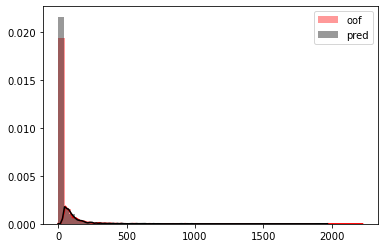

In [56]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)